# Alignment tutorial for 8months mouse brains
In this tutorial, we will demonstrate how to implement 8months mouse brains alignment using 3d-OT and calculate the chamfer distance

## Loading package

In [1]:
from lib_3d_OT.utils import *
import scanpy as sc
import numpy as np
import pandas as pd
import torch
from lib_3d_OT.single_modialty import *
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

During startup - Warning messages:
1: package ‘methods’ was built under R version 4.3.2 
2: package ‘datasets’ was built under R version 4.3.2 
3: package ‘utils’ was built under R version 4.3.2 
4: package ‘grDevices’ was built under R version 4.3.2 
5: package ‘graphics’ was built under R version 4.3.2 
6: package ‘stats’ was built under R version 4.3.2 
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



Could not load compiled 3D CUDA chamfer distance


In [2]:
import os
os.environ['R_HOME'] = '/home/dbj/anaconda3/envs/r/lib/R'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## Loading and Pre-processing two slices 
+ First, we need to prepare the single cell spatial data into AnnData objects. AnnData is the standard data class we use in 3d-OT. 
+ See [documentation](https://anndata.readthedocs.io/en/latest/index.html)for more details if you are unfamiliar, including how to construct AnnData objects from scratch, and how to read data in other formats (csv, mtx, loom, etc.) into AnnData objects.
+ `dpca`is the preprocessing process for reference [SLAT](https://www.nature.com/articles/s41467-023-43105-5)

In [3]:
adata1=sc.read_h5ad('/home/dbj/mouse/STARMAPPLUS/8months_disease2.h5ad')
adata2=sc.read_h5ad('/home/dbj/mouse/STARMAPPLUS/8months_disease1.h5ad')
adata2.obs['truth']=adata2.obs['region']
adata1.obs['truth']=adata1.obs['region']
adatalist=[adata1,adata2]
adata1,adata2=dpca(adatalist,n_comps=50,join='inner')

## Constructing neighbor graph and training the Pointnet++Encoder
We first build the neighbor graph `graph1` of rep1 and train the encoder to get a trained encoder `best_model1`

In [4]:
set_seed(7)
graph1 = prepare_data(adata2, location="spatial", nb_neighbors=8).to(device)
input_dim1 = graph1.express.shape[-1]
model = extractMODEL(args=None,input_dim=input_dim1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_model1, min_loss = train_graph_extractor(graph1, model, optimizer, device,epochs=800)

Epoch 800/800, Loss: 1.533769, Min Loss: 1.534344

## Constructing neighbor graph and training the Pointnet++Encoder
We then build the neighbor graph `graph2` of rep2 and train the encoder to get a trained encoder `best_model2`

In [5]:
set_seed(7)
graph2 = prepare_data(adata1, location="spatial", nb_neighbors=8).to(device)
input_dim2 = graph2.express.shape[-1]
model = extractMODEL(args=None,input_dim=input_dim2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_model2, min_loss = train_graph_extractor(graph2, model, optimizer, device,epochs=800)

Epoch 800/800, Loss: 1.500054, Min Loss: 1.471720

## Target alignment slice

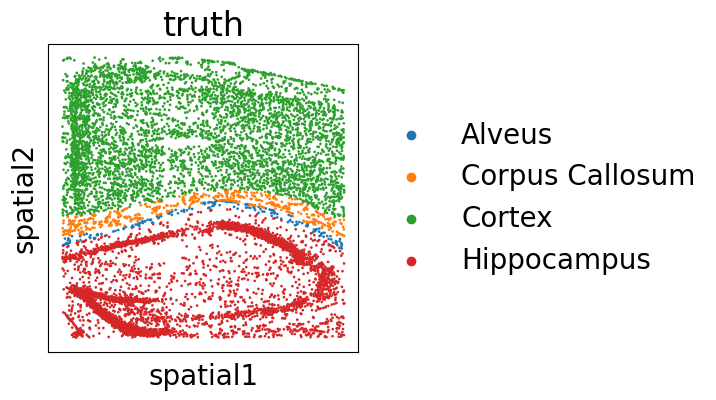

In [6]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 20

fig, ax = plt.subplots()
sc.pl.embedding(adata1,basis='spatial',color='truth',size=15,ax=ax)

## Source alignment slice

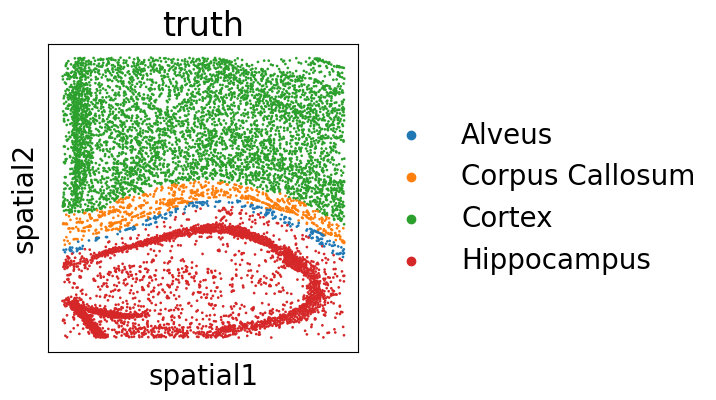

In [7]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 20

fig, ax = plt.subplots()
sc.pl.embedding(adata2,basis='spatial',color='truth',size=15,ax=ax)

## Training the optimal transport module
Enter graph1 and graph2 and the two encoders we trained into the optimal transport model

In [8]:
pclouds_list=[graph1,graph2]

In [9]:
input_dim1 = pclouds_list[0].express.shape[-1]
input_dim2 = pclouds_list[1].express.shape[-1]
model = UnifiedModel(input_dim1=input_dim1,input_dim2=input_dim2,simk=5,otk=50,reconk=1,best_encoder1=best_model1,best_encoder2=best_model2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
lr_lambda = lambda epoch: 1.0 if epoch < 340 else 1.0
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
args = {
    "backward_dist_weight":1.0,
    "use_smooth_flow":1,
    "smooth_flow_loss_weight":1.0,
    "use_div_flow":1,
    "div_flow_loss_weight":1.0,
    "div_neighbor": 8,
    "lattice_steps": 10,
    "nb_neigh_smooth_flow":32,
}



train(model=model,pcloud_list=pclouds_list,optimizer=optimizer,scheduler=scheduler,device=device,nb_epochs=1,use_corr_conf=False,use_smooth_flow=True,use_div_flow=True,args=args)

Time Pair 0,total_loss: 0.0756,smooth_flow_loss: 0.0459 Target Recon Loss: 0.0000,Div Flow Loss: 0.0296

## Visualize and quantify the evaluation of seven region alignment results
+ `selected_cell_type`represents the drawn source cell type.
+ `finaltruth` means that the target cell type corresponding to the source cell type that based on the biological understanding, and it is used to obtain the spatial location information of the target cell type and calculate the chamfer distance.
+ `all_arrow_ends`represents all aligned flow end positions from source cell type,it is used to calculate the chamfer distance.
+ `layer_1_pcloud_3D` represents the target cell type spatial position information based on biological understanding, and is used to calculate the chamfer distance.

## The alignment result of Alveus

Number of arrow ends: 213
Layer 1 points count: 186


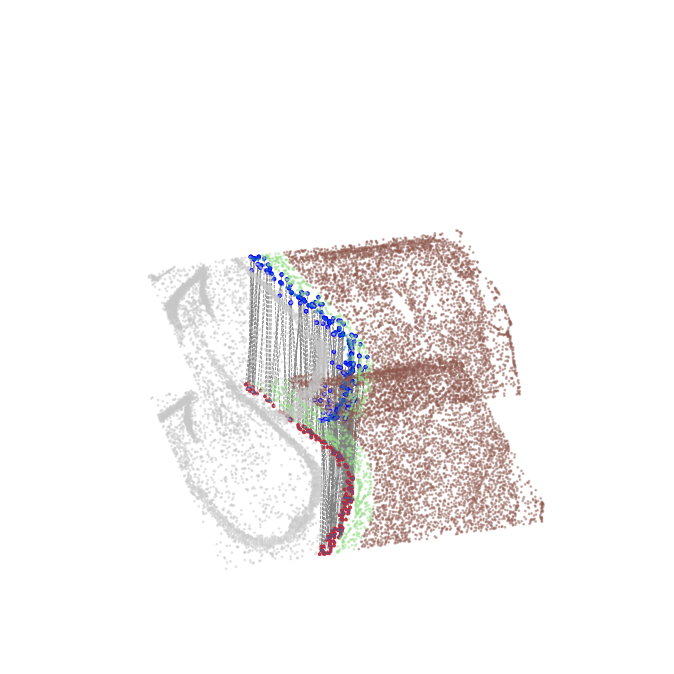

In [10]:
from lib_3d_OT.plot import *
all_arrow_ends,layer_1_pcloud_3D=plot_selected_cell_type_flow(pclouds_list, model, device,selected_cell_type='Alveus',finaltruth=['Alveus'],xlim=(-0.1, 1.1),ylim=(-0.1, 1.1),height_scale=1,size=1,alpha=0.4,
    #save_path='/home/dbj/DPLFC/'
)

`-Log10(chamfer_distance)` as a performance metric for alignment

In [11]:
chamfer_dist = chamfer_distance(all_arrow_ends,layer_1_pcloud_3D)

print(f"chamfer distance: {chamfer_dist}")

chamfer distance: 0.00040478422767053205


Number of arrow ends: 654
Layer 1 points count: 467


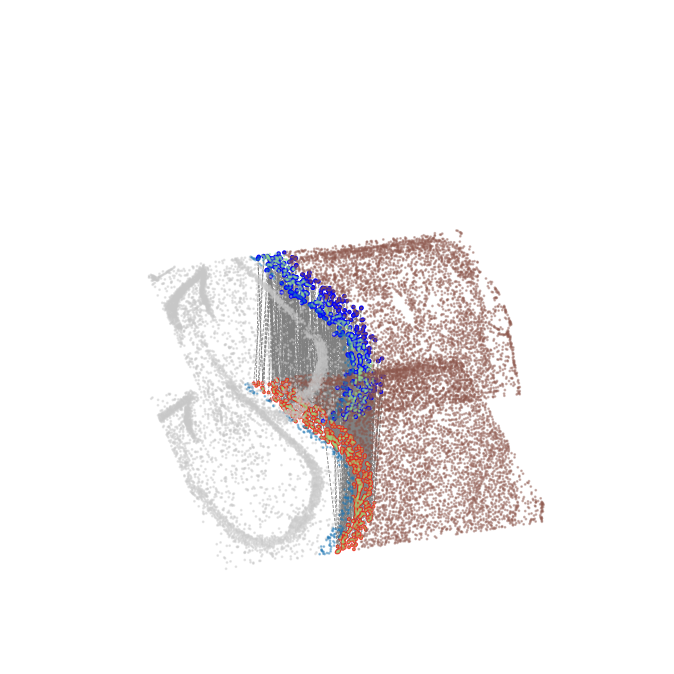

In [12]:
from lib_3d_OT.plot import *
all_arrow_ends,layer_1_pcloud_3D=plot_selected_cell_type_flow(pclouds_list, model, device,selected_cell_type='Corpus Callosum',finaltruth=['Corpus Callosum'],xlim=(-0.1, 1.1),ylim=(-0.1, 1.1),height_scale=1,size=1,alpha=0.4,
    #save_path='/home/dbj/DPLFC/'
)

In [13]:
chamfer_dist = chamfer_distance(all_arrow_ends,layer_1_pcloud_3D)

print(f"chamfer distance: {chamfer_dist}")

chamfer distance: 0.0002835519214628519


Number of arrow ends: 4666
Layer 1 points count: 4399


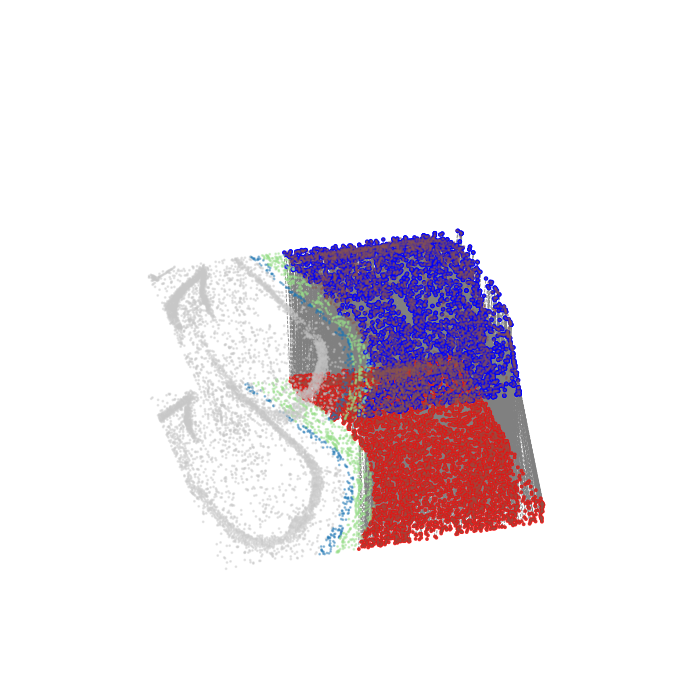

In [14]:
from lib_3d_OT.plot import *
all_arrow_ends,layer_1_pcloud_3D=plot_selected_cell_type_flow(pclouds_list, model, device,selected_cell_type='Cortex',finaltruth=['Cortex'],xlim=(-0.1, 1.1),ylim=(-0.1, 1.1),height_scale=1,size=1,alpha=0.4,
    #save_path='/home/dbj/DPLFC/'
)

In [15]:
chamfer_dist = chamfer_distance(all_arrow_ends,layer_1_pcloud_3D)

print(f"chamfer distance: {chamfer_dist}")

chamfer distance: 2.6951444131818508e-05


Number of arrow ends: 2653
Layer 1 points count: 3150


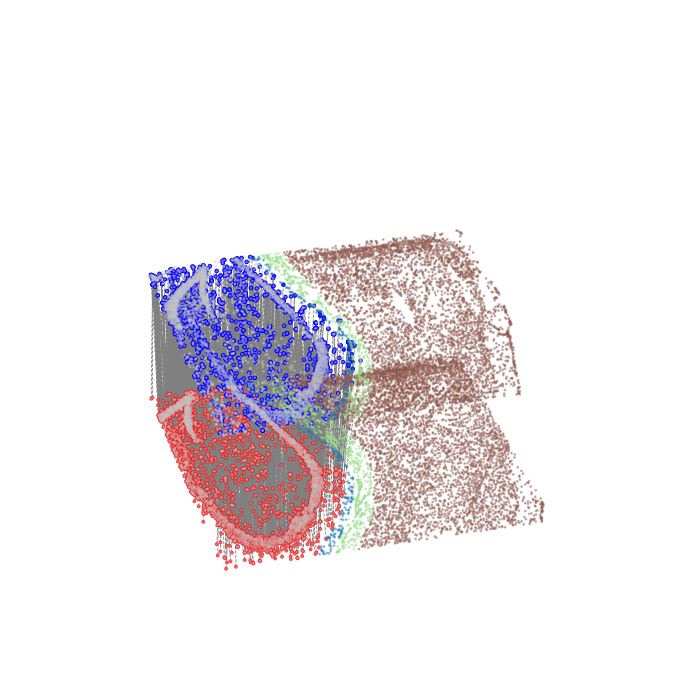

In [16]:
from lib_3d_OT.plot import *
all_arrow_ends,layer_1_pcloud_3D=plot_selected_cell_type_flow(pclouds_list, model, device,selected_cell_type='Hippocampus',finaltruth=['Hippocampus'],xlim=(-0.1, 1.1),ylim=(-0.1, 1.1),height_scale=1,size=1,alpha=0.4,
    #save_path='/home/dbj/DPLFC/'
)

In [17]:
chamfer_dist = chamfer_distance(all_arrow_ends,layer_1_pcloud_3D)

print(f"chamfer distance: {chamfer_dist}")

chamfer distance: 6.24529523107703e-05
